# Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql.functions import mean 

StatementMeta(sparkpool, 2, 2, Finished, Available)

# Lectura de Dataset Phishing

In [2]:
path = "abfss://practica-fs@roberwido.dfs.core.windows.net/phishing.csv"
phishing_df = spark.read.option("header", "true").option("inferSchema", "true").csv(path)

StatementMeta(sparkpool, 2, 3, Finished, Available)

In [3]:
# Visualizamos una fila
phishing_df.show()

StatementMeta(sparkpool, 1, 4, Finished, Available)

+---+--------------------+----------+---------------+---+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+------------+------------+---------------------+-----------+------------------+-----------------+--------+----+-----------+----------------+------------------+-------------+-------------+-------------+------------------+--------------+--------------+-----------------------+----------------+-----------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-------------+-------------+-------------+-----------+---------------+------------------+-------------+--------------+------------------+-------------+-------------------+-------------------+--------------------+---------+--------------------+--------------------+---------------+------------------+----------+----------------+-----------------+------------+--------------+------

In [4]:
# vemos los tipos de datos cargados
phishing_df.dtypes

StatementMeta(sparkpool, 1, 5, Finished, Available)

[('_c0', 'int'),
 ('url', 'string'),
 ('url_length', 'int'),
 ('hostname_length', 'int'),
 ('ip', 'int'),
 ('total_of.', 'int'),
 ('total_of-', 'int'),
 ('total_of@', 'int'),
 ('total_of?', 'int'),
 ('total_of&', 'int'),
 ('total_of=', 'int'),
 ('total_of_', 'int'),
 ('total_of~', 'int'),
 ('total_of%', 'int'),
 ('total_of/', 'int'),
 ('total_of*', 'int'),
 ('total_of:', 'int'),
 ('total_of,', 'int'),
 ('total_of;', 'int'),
 ('total_of$', 'int'),
 ('total_of_www', 'int'),
 ('total_of_com', 'int'),
 ('total_of_http_in_path', 'int'),
 ('https_token', 'int'),
 ('ratio_digits_url', 'double'),
 ('ratio_digits_host', 'double'),
 ('punycode', 'int'),
 ('port', 'int'),
 ('tld_in_path', 'int'),
 ('tld_in_subdomain', 'int'),
 ('abnormal_subdomain', 'int'),
 ('nb_subdomains', 'int'),
 ('prefix_suffix', 'int'),
 ('random_domain', 'int'),
 ('shortening_service', 'int'),
 ('path_extension', 'int'),
 ('nb_redirection', 'int'),
 ('nb_external_redirection', 'int'),
 ('length_words_raw', 'int'),
 ('char

In [5]:
# visualizamos informacion de las columnas
phishing_df.printSchema()

StatementMeta(sparkpool, 1, 6, Finished, Available)

root
 |-- _c0: integer (nullable = true)
 |-- url: string (nullable = true)
 |-- url_length: integer (nullable = true)
 |-- hostname_length: integer (nullable = true)
 |-- ip: integer (nullable = true)
 |-- total_of.: integer (nullable = true)
 |-- total_of-: integer (nullable = true)
 |-- total_of@: integer (nullable = true)
 |-- total_of?: integer (nullable = true)
 |-- total_of&: integer (nullable = true)
 |-- total_of=: integer (nullable = true)
 |-- total_of_: integer (nullable = true)
 |-- total_of~: integer (nullable = true)
 |-- total_of%: integer (nullable = true)
 |-- total_of/: integer (nullable = true)
 |-- total_of*: integer (nullable = true)
 |-- total_of:: integer (nullable = true)
 |-- total_of,: integer (nullable = true)
 |-- total_of;: integer (nullable = true)
 |-- total_of$: integer (nullable = true)
 |-- total_of_www: integer (nullable = true)
 |-- total_of_com: integer (nullable = true)
 |-- total_of_http_in_path: integer (nullable = true)
 |-- https_token: intege

In [6]:
# Eliminamos la primera columna que actua como índice
phishing_df = phishing_df.drop('_c0')

StatementMeta(sparkpool, 2, 7, Finished, Available)

In [7]:
# Vamos a comprobar los valores únicos para la columna 'domain_with_copyright'
unique_values = phishing_df.select('domain_with_copyright').distinct().collect()
unique_values

StatementMeta(sparkpool, 1, 8, Finished, Available)

[Row(domain_with_copyright='One'),
 Row(domain_with_copyright='0'),
 Row(domain_with_copyright='one'),
 Row(domain_with_copyright='zero'),
 Row(domain_with_copyright='Zero'),
 Row(domain_with_copyright='1')]

In [8]:
# Revisar los tipos de cada valor
for row in unique_values:
    value = row[0]
    data_type = type(value).__name__
    print(f"Value: {value}, Data Type: {data_type}")


StatementMeta(sparkpool, 1, 9, Finished, Available)

Value: One, Data Type: str
Value: 0, Data Type: str
Value: one, Data Type: str
Value: zero, Data Type: str
Value: Zero, Data Type: str
Value: 1, Data Type: str


In [7]:
# Como vemos que hay 4 tipos de valor para 1 y 0, transformamos la columna para que solo acepte valores enteros
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def transform_domain_with_copyright(x):
    if x in ['one', 'One', '1']:
        return 1
    else:
        return 0

# Definir un UDF con la transformacion
transform_udf = udf(transform_domain_with_copyright, IntegerType())

phishing_df = phishing_df.withColumn('domain_with_copyright', transform_udf(phishing_df['domain_with_copyright']))

StatementMeta(sparkpool, 2, 8, Finished, Available)

In [10]:
# confirmamos que la transformacion se ha hecho correctamente
unique_values = phishing_df.select('domain_with_copyright').distinct().collect()
unique_values

StatementMeta(sparkpool, 1, 11, Finished, Available)

[Row(domain_with_copyright=1), Row(domain_with_copyright=0)]

In [11]:
# Comprobamos la columna que utilizaremos como label, ¿qué valores únicos tiene?
unique_labels = phishing_df.select('status').distinct().collect()
unique_labels

StatementMeta(sparkpool, 1, 12, Finished, Available)

[Row(status='phishing'), Row(status='legitimate')]

In [8]:
# Como vemos que hay 4 tipos de valor para 1 y 0, transformamos la columna para que solo acepte valores enteros
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def transform_label(x):
    if x == 'phishing':
        return 1
    else:
        return 0

# Definir un UDF con la transformacion
transform_udf_label = udf(transform_label, IntegerType())
phishing_df = phishing_df.withColumn('status', transform_udf_label(phishing_df['status']))

StatementMeta(sparkpool, 2, 9, Finished, Available)

In [13]:
# confirmamos que la transformacion se ha hecho correctamente
unique_values = phishing_df.select('status').distinct().collect()
unique_values

StatementMeta(sparkpool, 1, 14, Finished, Available)

[Row(status=1), Row(status=0)]

In [14]:
phishing_df.head()

StatementMeta(sparkpool, 1, 15, Finished, Available)

Row(url='http://www.progarchives.com/album.asp?id=61737', url_length=46, hostname_length=20, ip=0, total_of.=3, total_of-=0, total_of@=0, total_of?=1, total_of&=0, total_of==1, total_of_=0, total_of~=0, total_of%=0, total_of/=3, total_of*=0, total_of:=1, total_of,=0, total_of;=0, total_of$=0, total_of_www=1, total_of_com=0, total_of_http_in_path=0, https_token=1, ratio_digits_url=0.1086956519999999, ratio_digits_host=0.0, punycode=0, port=0, tld_in_path=0, tld_in_subdomain=0, abnormal_subdomain=0, nb_subdomains=3, prefix_suffix=0, random_domain=0, shortening_service=0, path_extension=0, nb_redirection=0, nb_external_redirection=0, length_words_raw=6, char_repeat=3, shortest_words_raw=2, shortest_word_host=3, shortest_word_path=2, longest_words_raw=12, longest_word_host=12, longest_word_path=5, avg_words_raw=5.0, avg_word_host=7.5, avg_word_path=3.75, phish_hints=0, domain_in_brand=0, brand_in_subdomain=0, brand_in_path=0, suspecious_tld=0, statistical_report=0, nb_hyperlinks=143, ratio

# Análisis de los datos

In [3]:
# transformamos a dataframe de pandas
df = phishing_df.toPandas()

StatementMeta(sparkpool, 2, 4, Finished, Available)

In [16]:
# análisis estadístico de cada columna
summary_stats = df.describe()
summary_stats

StatementMeta(sparkpool, 1, 17, Finished, Available)

,url_length,hostname_length,ip,total_of.,total_of-,total_of@,total_of?,total_of&,total_of=,total_of_,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
count,19431.000000,19431.000000,19431.000000,19431.000000,19431.000000,19431.000000,19431.000000,19431.000000,19431.000000,19431.000000,...,19431.000000,19431.000000,19431.000000,19431.000000,19431.000000,1.943100e+04,19431.000000,19431.000000,19431.000000,19431.000000
mean,61.134527,21.101127,0.649529,2.485564,0.997684,0.021872,0.141012,0.164994,0.296125,0.324481,...,0.774793,0.440276,0.072873,492.192013,4063.306932,8.595096e+05,0.020328,0.533992,3.190263,0.499974
std,56.205292,10.719241,0.477130,1.383635,2.076148,0.155149,0.364934,0.842362,1.018564,1.111470,...,0.417729,0.496433,0.259935,803.880801,3107.806494,1.998160e+06,0.141125,0.498856,2.535792,0.500013
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-12.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,33.000000,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,84.000000,971.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000
50%,47.000000,19.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,244.000000,4003.000000,1.885000e+03,0.000000,1.000000,3.000000,0.000000
75%,71.000000,24.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,449.000000,7026.000000,3.756425e+05,0.000000,1.000000,5.000000,1.000000
max,1641.000000,214.000000,1.000000,24.000000,43.000000,4.000000,3.000000,19.000000,19.000000,18.000000,...,1.000000,1.000000,1.000000,29829.000000,12874.000000,1.076799e+07,1.000000,1.000000,10.000000,1.000000


In [17]:
# Matriz de correlacion
correlation_matrix = df.corr()
correlation_matrix

StatementMeta(sparkpool, 1, 18, Finished, Available)

/tmp/ipykernel_7757/2805616672.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


,url_length,hostname_length,ip,total_of.,total_of-,total_of@,total_of?,total_of&,total_of=,total_of_,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
url_length,1.000000,0.217586,0.139063,0.447198,0.406951,0.148334,0.523172,0.587389,0.631574,0.443290,...,0.124224,-0.004281,-0.004768,0.002408,-0.006400,0.072773,0.024539,0.233061,-0.099900,0.244348
hostname_length,0.217586,1.000000,0.077150,0.406834,0.059480,0.070095,0.164129,0.142347,0.179735,0.080048,...,0.218850,0.073107,-0.100543,-0.047856,0.011504,0.161418,-0.022895,0.216919,-0.160621,0.240681
ip,0.139063,0.077150,1.000000,0.086433,0.034718,0.020823,0.127186,0.115839,0.134242,0.064511,...,0.045277,0.004624,0.018370,-0.033800,-0.024471,0.050773,0.041608,0.084218,-0.069010,0.098335
total_of.,0.447198,0.406834,0.086433,1.000000,0.049303,0.264595,0.353133,0.443665,0.423621,0.344787,...,0.108442,0.057320,0.060881,-0.029248,-0.010983,0.086857,0.132368,0.208764,-0.098752,0.205302
total_of-,0.406951,0.059480,0.034718,0.049303,1.000000,0.019011,0.035958,0.130734,0.115807,0.051177,...,0.009843,0.020914,-0.056718,0.039414,0.080796,-0.041968,-0.031282,-0.018285,0.104676,-0.102849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
web_traffic,0.072773,0.161418,0.050773,0.086857,-0.041968,-0.014132,0.142186,0.162469,0.185492,0.090583,...,0.082745,0.082961,0.025569,-0.114610,-0.099957,1.000000,-0.011527,0.033618,-0.211007,0.060531
dns_record,0.024539,-0.022895,0.041608,0.132368,-0.031282,0.031405,0.010293,0.079153,0.055150,0.061630,...,0.062821,0.042675,0.219171,-0.061376,-0.072481,-0.011527,1.000000,0.095822,-0.145565,0.123634
google_index,0.233061,0.216919,0.084218,0.208764,-0.018285,0.113746,0.202097,0.131298,0.169296,0.073718,...,0.265933,-0.144499,0.040035,-0.130972,-0.210101,0.033618,0.095822,1.000000,-0.386721,0.730684
page_rank,-0.099900,-0.160621,-0.069010,-0.098752,0.104676,-0.065521,-0.123151,-0.123435,-0.131230,0.008699,...,-0.332742,0.057127,-0.158069,0.350234,0.591275,-0.211007,-0.145565,-0.386721,1.000000,-0.509761


StatementMeta(sparkpool, 1, 19, Finished, Available)

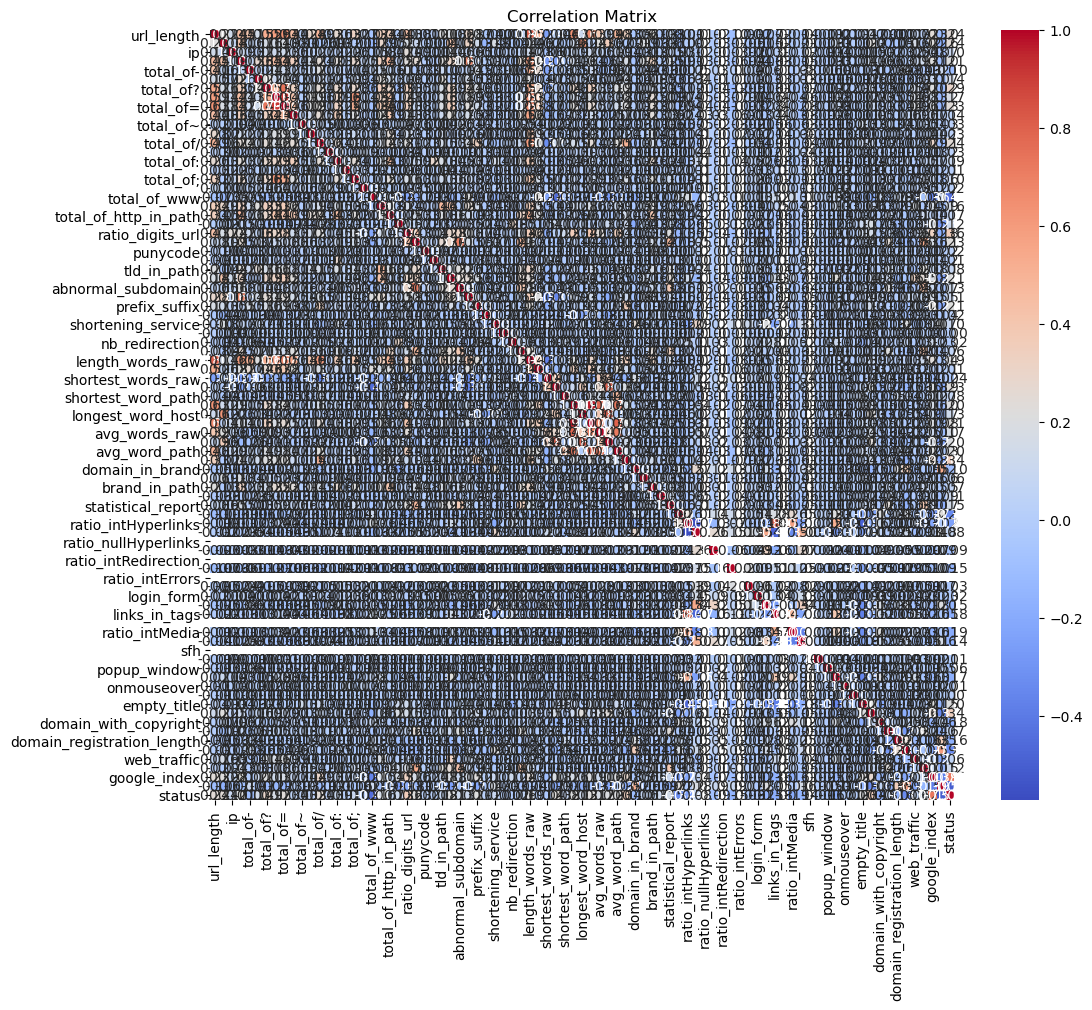

In [18]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

StatementMeta(sparkpool, 1, 20, Finished, Available)

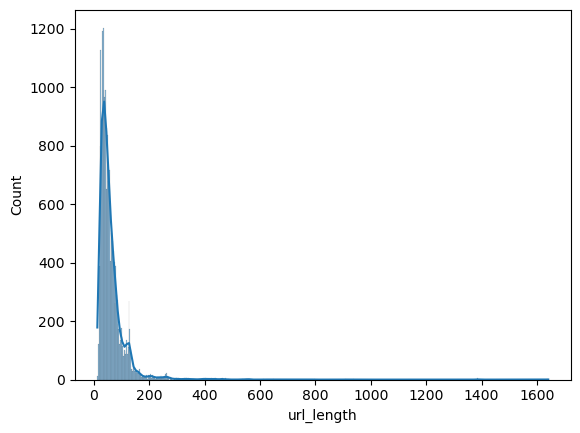

In [19]:
# Revisamos columnas importantes con histogramas
sns.histplot(data=df, x='url_length', kde=True)
plt.show()

StatementMeta(sparkpool, 1, 21, Finished, Available)

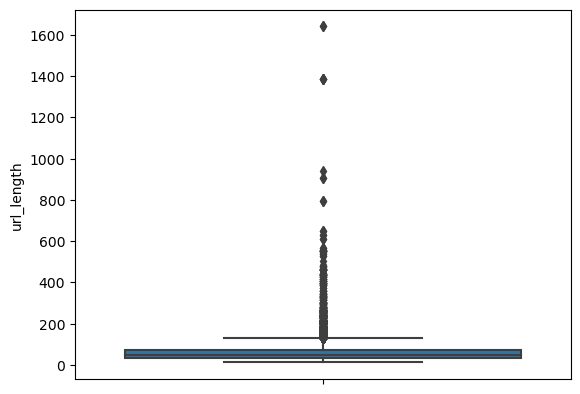

In [20]:
# Plot boxplots for numerical columns
sns.boxplot(data=df, y='url_length')
plt.show()

StatementMeta(sparkpool, 1, 22, Finished, Available)

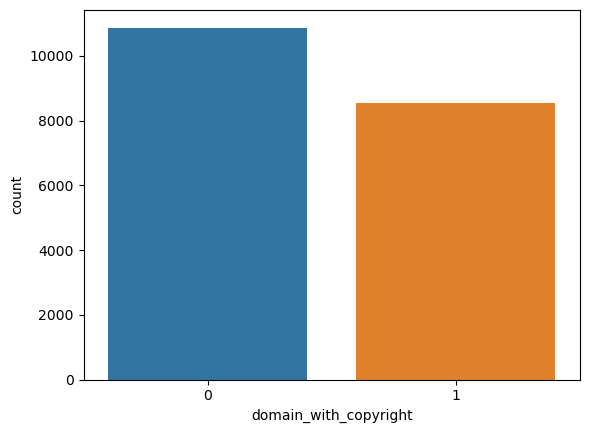

In [21]:
sns.countplot(data=df, x='domain_with_copyright')
plt.show()

StatementMeta(sparkpool, 1, 23, Finished, Available)

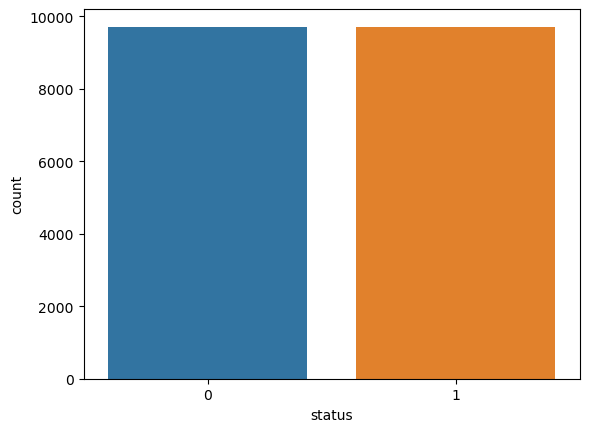

In [22]:
sns.countplot(data=df, x='status')
plt.show()

In [4]:
# Nos aseguramos de que no existan valores nulos
df.isnull().sum()

StatementMeta(sparkpool, 2, 5, Finished, Available)

_c0                0
url                0
url_length         0
hostname_length    0
ip                 0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 87, dtype: int64

# Guardado del dataset curado

In [23]:
target_path = "abfss://practica-fs@roberwido.dfs.core.windows.net/phishing_curated.csv"
phishing_df.write.csv(target_path, mode='overwrite')

StatementMeta(sparkpool, 1, 24, Finished, Available)

# Procesamiento del dataset para las pipelines de Azure ML

Debido a que las columnas que tienen nombres con caracteres del tipo ,.-@/ etc. fallan al ser procesadas en un pipeline de Azure ML, modificaremos todos los nombres para que desaparezcan esos caracteres y funcione con normalidad

('total_of.', 'int'),
 ('total_of-', 'int'),
 ('total_of@', 'int'),
 ('total_of?', 'int'),
 ('total_of&', 'int'),
 ('total_of=', 'int'),
 ('total_of_', 'int'),
 ('total_of~', 'int'),
 ('total_of%', 'int'),
 ('total_of/', 'int'),
 ('total_of*', 'int'),
 ('total_of:', 'int'),
 ('total_of,', 'int'),
 ('total_of;', 'int'),
 ('total_of$', 'int'),

In [11]:
phishing_df = phishing_df.withColumnRenamed('total_of.', 'total_of_points') \
                        .withColumnRenamed('total_of-', 'total_of_hyphens') \
                        .withColumnRenamed('total_of@', 'total_of_ats') \
                        .withColumnRenamed('total_of?', 'total_of_questionmarks') \
                        .withColumnRenamed('total_of&', 'total_of_ampersands') \
                        .withColumnRenamed('total_of=', 'total_of_equals') \
                        .withColumnRenamed('total_of_', 'total_of_underscores') \
                        .withColumnRenamed('total_of~', 'total_of_tildes') \
                        .withColumnRenamed('total_of%', 'total_of_percentages') \
                        .withColumnRenamed('total_of/', 'total_of_slashes') \
                        .withColumnRenamed('total_of*', 'total_of_stars') \
                        .withColumnRenamed('total_of:', 'total_of_colons') \
                        .withColumnRenamed('total_of,', 'total_of_commas') \
                        .withColumnRenamed('total_of;', 'total_of_semicolon') \
                        .withColumnRenamed('total_of$', 'total_of_dollars')
                        
phishing_df.printSchema()

StatementMeta(sparkpool, 2, 12, Finished, Available)

root
 |-- url: string (nullable = true)
 |-- url_length: integer (nullable = true)
 |-- hostname_length: integer (nullable = true)
 |-- ip: integer (nullable = true)
 |-- total_of_points: integer (nullable = true)
 |-- total_of_hyphens: integer (nullable = true)
 |-- total_of_ats: integer (nullable = true)
 |-- total_of_questionmarks: integer (nullable = true)
 |-- total_of_ampersands: integer (nullable = true)
 |-- total_of_equals: integer (nullable = true)
 |-- total_of_underscores: integer (nullable = true)
 |-- total_of_tildes: integer (nullable = true)
 |-- total_of_percentages: integer (nullable = true)
 |-- total_of_slashes: integer (nullable = true)
 |-- total_of_stars: integer (nullable = true)
 |-- total_of_colons: integer (nullable = true)
 |-- total_of_commas: integer (nullable = true)
 |-- total_of_semicolon: integer (nullable = true)
 |-- total_of_dollars: integer (nullable = true)
 |-- total_of_www: integer (nullable = true)
 |-- total_of_com: integer (nullable = true)
 

In [12]:
target_path = "abfss://practica-fs@roberwido.dfs.core.windows.net/phishing_curated_pipeline.csv"
phishing_df.write.csv(target_path, mode='overwrite')

StatementMeta(sparkpool, 2, 13, Finished, Available)